<a href="https://colab.research.google.com/github/mille055/AIPI540_individual_project/blob/main/notebooks/Train_pixel_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Connect to the data which is in Google Drive
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#install pydicom for reading the dicom data
!pip install pydicom monai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 73.8 MB/s eta 0:00:00


In [5]:
# imports
from __future__ import print_function
import sys
from random import shuffle

import os
import os.path
import glob
import numpy as np
import tensorflow as tf
import csv
import pydicom
import cv2
import configparser
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import time
import os
import copy

import monai
from monai.data import DataLoader, ImageDataset
from monai.transforms import AddChannel, Compose, RandRotate90, Resize, ScaleIntensity, EnsureType


In [6]:
data_dir = '/content/gdrive/MyDrive/WW_MRI_abd2/split/'
#train_df = pd.read_pickle(data_dir+'train_img_df.pkl')
#test_df = pd.read_pickle(data_dir+'test_img_df.pkl')
train_csv = pd.read_csv(data_dir + 'trainfiles.csv')
test_csv = pd.read_csv(data_dir + 'testfiles.csv')

#run once at start to rid unneccesary column
train_csv.drop('Unnamed: 0', axis=1, inplace=True)
test_csv.drop('Unnamed: 0', axis=1, inplace=True)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# #train_get_mid = train_csv.groupby(['patientID', 'series']).agg({'img_num': lambda x: sorted(x.to_list())})
# df = train_csv.copy()

# grouped_df = df.groupby(['patientID', 'series'])
# sorted_df = grouped_df['file_info'].apply(lambda x: x.sort_values())
# sorted_df
# middle_filename = grouped_df['file_info'].apply(lambda x: x.sort_values().iloc[len(x)//2])
# middle_filename = middle_filename.reset_index()
# df = df.merge(middle_filename, on=['patientID', 'series'], how='left')
# pd.options.display.max_colwidth = 100
# train_csv_short = df.drop(['file_info_x', 'img_num'], axis=1)
# train_csv_short.rename(columns = {'file_info_y': 'file_info'})
# train_csv_short.drop_duplicates(inplace=True)
# train_csv_short





In [10]:
# this function will select the image in the middle of each series of images, so that only a single image from each series is selected for training
# There is one image from each series for each patient
def shorten_df(df):
  df1 = df.copy()
  grouped_df = df.groupby(['patientID', 'series'])
  sorted_df = grouped_df['file_info'].apply(lambda x: x.sort_values())

  middle_filename = grouped_df['file_info'].apply(lambda x: x.sort_values().iloc[len(x)//2])
  middle_filename = middle_filename.reset_index()
  
  # perform merge and deal with duplicate/unnecessary columns
  df1 = df1.merge(middle_filename, on=['patientID', 'series'], how='left') 
  df_short = df1.drop(['file_info_x', 'img_num'], axis=1)
  df_short = df_short.rename(columns = {'file_info_y': 'file_info'})
  df_short.drop_duplicates(inplace=True)
  df_short.reset_index(drop=True, inplace=True)
  return df_short

In [11]:
# create shortened dataframes for train and test
train_csv_short = shorten_df(train_csv)
test_csv_short = shorten_df(test_csv)


In [12]:
test_csv_short

,label,patientID,series,file_info
0,8,102,16(1-40),/volumes/cm7/Abdominal_MRI_dataset_split/test/...
1,8,102,16(41-80),/volumes/cm7/Abdominal_MRI_dataset_split/test/...
2,16,102,18,/volumes/cm7/Abdominal_MRI_dataset_split/test/...
3,3,102,11,/volumes/cm7/Abdominal_MRI_dataset_split/test/...
4,25,102,7,/volumes/cm7/Abdominal_MRI_dataset_split/test/...
...,...,...,...,...
441,8,58,16(1-36),/volumes/cm7/Abdominal_MRI_dataset_split/test/...
442,7,58,2,/volumes/cm7/Abdominal_MRI_dataset_split/test/...
443,2,58,13,/volumes/cm7/Abdominal_MRI_dataset_split/test/...
444,14,58,5,/volumes/cm7/Abdominal_MRI_dataset_split/test/...


In [13]:
train_csv_short

,label,patientID,series,file_info
0,8,104,18(35-68),/volumes/cm7/Abdominal_MRI_dataset_split/train...
1,8,104,18(1-34),/volumes/cm7/Abdominal_MRI_dataset_split/train...
2,16,104,20,/volumes/cm7/Abdominal_MRI_dataset_split/train...
3,9,104,9,/volumes/cm7/Abdominal_MRI_dataset_split/train...
4,9,104,11,/volumes/cm7/Abdominal_MRI_dataset_split/train...
...,...,...,...,...
1761,7,94,3,/volumes/cm7/Abdominal_MRI_dataset_split/train...
1762,2,94,12,/volumes/cm7/Abdominal_MRI_dataset_split/train...
1763,2,94,13,/volumes/cm7/Abdominal_MRI_dataset_split/train...
1764,19,94,5,/volumes/cm7/Abdominal_MRI_dataset_split/train...


In [14]:
#create train, val, and test datasets from the csv files, using same val list as metadata classifier

#using same train/val/test split as in the original split based on the metadata classifier
val_list = [41, 84, 14, 25, 76, 47,62,0,55,63,101,18,81,3,4,95,66]

val_df = train_csv_short[train_csv_short.patientID.isin(val_list)]
train_df = train_csv_short[~train_csv_short.index.isin(val_df.index)]
test_df = test_csv_short


train = train_df.reset_index(drop=True)
val = val_df.reset_index(drop=True)
test = test_df.reset_index(drop=True)

#sanity check
print(len(val)+len(train), len(test))
display(val.head(), train.head())

1766 446


,label,patientID,series,file_info
0,8,41,16(37-72),/volumes/cm7/Abdominal_MRI_dataset_split/train...
1,16,41,18,/volumes/cm7/Abdominal_MRI_dataset_split/train...
2,3,41,11,/volumes/cm7/Abdominal_MRI_dataset_split/train...
3,25,41,7,/volumes/cm7/Abdominal_MRI_dataset_split/train...
4,11,41,6,/volumes/cm7/Abdominal_MRI_dataset_split/train...


,label,patientID,series,file_info
0,8,104,18(35-68),/volumes/cm7/Abdominal_MRI_dataset_split/train...
1,8,104,18(1-34),/volumes/cm7/Abdominal_MRI_dataset_split/train...
2,16,104,20,/volumes/cm7/Abdominal_MRI_dataset_split/train...
3,9,104,9,/volumes/cm7/Abdominal_MRI_dataset_split/train...
4,9,104,11,/volumes/cm7/Abdominal_MRI_dataset_split/train...


In [15]:
# Data cropping and normalization, also converts single channel to 3 channel for the model
data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(299),
        transforms.CenterCrop(299),
        #transforms.RandomHorizontalFlip(),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

In [16]:
# custom datasest - gets the image data using pydicom.dcmread and transforms
# also gets label from the label column and merges classes 2-5 which are all flavors
# arterial into a single 'arterial' label as label 2

class ImgDataset(Dataset):
    def __init__(self, df, transform=None):
        self.data_df = df
        self.datafileslist = df.file_info
        self.labels = df.label
        self.transform = transform
        
        
    def __len__(self):
        return self.data_df.shape[0]
    
    def __getitem__(self, idx):
        source = '/volumes/cm7/Abdominal_MRI_dataset_split/'
        dest = '/content/gdrive/MyDrive/WW_MRI_abd2/split/'

        img_file = self.data_df.file_info[idx]
        rel = os.path.relpath(img_file, source)
        img_file_new = os.path.join(dest,rel)
        
        #print('getting file', img_file)
        ds = pydicom.dcmread(img_file_new)
        img = np.array(ds.pixel_array, dtype=np.float32)
        #img = img/255.
        #img = cv2.resize(img, (224,224))
        img = img[np.newaxis]
        img = torch.from_numpy(np.asarray(img))
        
        #print(img.dtype, img.shape)
        
        
        if self.transform:
            img = self.transform(img)
        #print('after transform', img.dtype, img.shape)
            
        x = img
        labl = self.data_df.label[idx]
      
        if labl in [2,3,4,5]: 
          labl=2
        y = torch.tensor(labl, dtype = torch.float32)
        #print(x,y)
        return (x,y)
        

In [17]:
#dataloaders
train_imgdata = ImgDataset(train, data_transforms['train'])
train_loader = DataLoader(train_imgdata, batch_size=8, shuffle=True)

val_imgdata = ImgDataset(val, data_transforms['val'])
val_loader = DataLoader(val_imgdata, batch_size=8, shuffle=True)

test_imgdata = ImgDataset(test, data_transforms['test'])
test_loader = DataLoader(test_imgdata, batch_size=8, shuffle=False)

dataset_sizes = {'train':len(train_imgdata),'val':len(val_imgdata)}


In [19]:
#visualization
def imshow(img, title):
    img = torchvision.utils.make_grid(img, normalize=True)
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)

    plt.axis('off')
    plt.show()

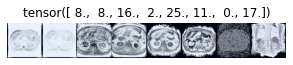

In [20]:
test_next_batch = next(iter(test_loader))
#print(train_next_batch[0])
imshow(test_next_batch[0], (test_next_batch[1]))

In [21]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            batch_num = 0
            for inputs, labels in dataloaders[phase]:
                print('batch ', batch_num)
                batch_num= batch_num + 1
                inputs = inputs.to(device)
                labels = labels.type(torch.LongTensor)
                labels = labels.to(device)
                
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [22]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [23]:
# use resnet50 transfer learning
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features

# output
model_ft.fc = nn.Linear(num_ftrs, 30)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [24]:
# train model for 25 epochs
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Streaming output truncated to the last 5000 lines.
batch  43
batch  44
val Loss: 0.6845 Acc: 0.7910

Epoch 3/24
----------
batch  0
batch  1
batch  2
batch  3
batch  4
batch  5
batch  6
batch  7
batch  8
batch  9
batch  10
batch  11
batch  12
batch  13
batch  14
batch  15
batch  16
batch  17
batch  18
batch  19
batch  20
batch  21
batch  22
batch  23
batch  24
batch  25
batch  26
batch  27
batch  28
batch  29
batch  30
batch  31
batch  32
batch  33
batch  34
batch  35
batch  36
batch  37
batch  38
batch  39
batch  40
batch  41
batch  42
batch  43
batch  44
batch  45
batch  46
batch  47
batch  48
batch  49
batch  50
batch  51
batch  52
batch  53
batch  54
batch  55
batch  56
batch  57
batch  58
batch  59
batch  60
batch  61
batch  62
batch  63
batch  64
batch  65
batch  66
batch  67
batch  68
batch  69
batch  70
batch  71
batch  72
batch  73
batch  74
batch  75
batch  76
batch  77
batch  78
batch  79
batch  80
batch  81
batch  82
batch  83
batch  84
batch  85
batch  86
batch  87
batch  

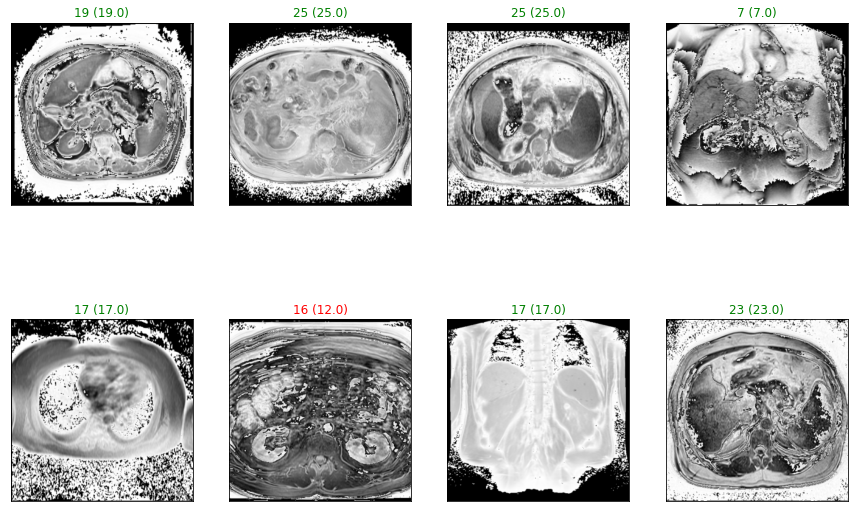

In [26]:
# Display a batch of predictions

def visualize_results(model,dataloader,device):
    model = model.to(device) # Send model to GPU if available
    with torch.no_grad():
        model.eval()
        # Get a batch of validation images
        images, labels = next(iter(val_loader))
        images, labels = images.to(device), labels.to(device)
        # Get predictions
        _,preds = torch.max(model(images), 1)
        preds = np.squeeze(preds.cpu().numpy())
        images = images.cpu().numpy()

    # Plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(15, 10))
    for idx in np.arange(len(preds)):
        ax = fig.add_subplot(2, len(preds)//2, idx+1, xticks=[], yticks=[])
        image = images[idx]
        image = image.transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = (std * image + mean)
        
        image = np.clip(image, 0, 1)
        ax.imshow(image)
        ax.set_title("{} ({})".format(preds[idx], labels[idx]),
                    color=("green" if preds[idx]==labels[idx] else "red"))
    return

visualize_results(model_ft,val_loader,device)

In [27]:
def test_model(model,test_loader,device):
    model = model.to(device)
    # Turn autograd off
    with torch.no_grad():

        # Set the model to evaluation mode
        model.eval()

        # Set up lists to store true and predicted values
        y_true = []
        test_preds = []

        # Calculate the predictions on the test set and add to list
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            # Feed inputs through model to get raw scores
            logits = model.forward(inputs)
            #print(labels, logits.sum())
            # Convert raw scores to probabilities (not necessary since we just care about discrete probs in this case)
            probs = torch.softmax(logits, dim=1)
            probs = probs.detach().cpu().numpy()
            #print(labels, probs)
            # Get discrete predictions using argmax
            preds = np.argmax(probs,axis=1)
            # Add predictions and actuals to lists
            test_preds.extend(preds)
            y_true.extend(labels.detach().cpu().numpy())

        # Calculate the accuracy
        test_preds = np.array(test_preds)
        y_true = np.array(y_true)
        test_acc = np.sum(test_preds == y_true)/y_true.shape[0]
        
        # Recall for each class
        recall_vals = []
        for i in range(32):
            class_idx = np.argwhere(y_true==i)
            total = len(class_idx)
            correct = np.sum(test_preds[class_idx]==i)
            recall = correct / total
            recall_vals.append(recall)
    
    return test_acc,recall_vals, test_preds, y_true

In [28]:
# Test the pre-trained model
#classes = set(train.label)
acc,recall_vals, test_preds, ytrue = test_model(model_ft,test_loader,device)
print('Test set accuracy is {:.3f}'.format(acc))

for i in range(len(recall_vals)):
    print('For class {}, recall is {}'.format(i,recall_vals[i]))

Test set accuracy is 0.886
For class 0, recall is 1.0
For class 1, recall is nan
For class 2, recall is 0.819672131147541
For class 3, recall is nan
For class 4, recall is nan
For class 5, recall is nan
For class 6, recall is 1.0
For class 7, recall is 1.0
For class 8, recall is 1.0
For class 9, recall is 0.9761904761904762
For class 10, recall is nan
For class 11, recall is 1.0
For class 12, recall is 0.0
For class 13, recall is 0.0
For class 14, recall is 0.9130434782608695
For class 15, recall is nan
For class 16, recall is 0.5
For class 17, recall is 0.9523809523809523
For class 18, recall is 1.0
For class 19, recall is 1.0
For class 20, recall is nan
For class 21, recall is 1.0
For class 22, recall is 1.0
For class 23, recall is 0.65
For class 24, recall is nan
For class 25, recall is 0.8936170212765957
For class 26, recall is 1.0
For class 27, recall is nan
For class 28, recall is nan
For class 29, recall is nan
For class 30, recall is nan
For class 31, recall is nan


<ipython-input-27-b1f34618c8b6>:40: RuntimeWarning: invalid value encountered in long_scalars
  recall = correct / total


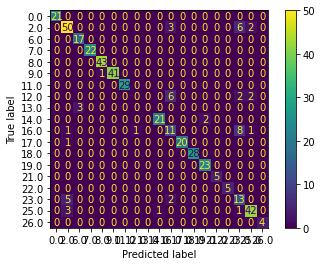

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
ConfusionMatrixDisplay.from_predictions(ytrue, test_preds)

In [33]:
print(classification_report(ytrue, test_preds))


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        21
         2.0       0.83      0.82      0.83        61
         6.0       0.85      1.00      0.92        17
         7.0       1.00      1.00      1.00        22
         8.0       0.98      1.00      0.99        43
         9.0       1.00      0.98      0.99        42
        11.0       1.00      1.00      1.00        29
        12.0       0.00      0.00      0.00        10
        13.0       0.00      0.00      0.00         3
        14.0       0.95      0.91      0.93        23
        16.0       0.50      0.50      0.50        22
        17.0       1.00      0.95      0.98        21
        18.0       1.00      1.00      1.00        28
        19.0       0.92      1.00      0.96        23
        21.0       1.00      1.00      1.00         5
        22.0       1.00      1.00      1.00         5
        23.0       0.43      0.65      0.52        20
        25.0       0.89    

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model_dn = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)
model_dn.fc = nn.Linear(num_ftrs, 32)

model_dn = model_dn.to(device)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [ ]:
model_iv3 = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
model_iv3.fc = nn.Linear(num_ftrs, 32)

model_iv3 = model_iv3.to(device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [ ]:
model_iv3 = train_model(model_iv3, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------
batch  0


TypeError: ignored

In [ ]:
torch.save(model_ft.state_dict(), 'model_res50addednorm012723')

In [ ]:
model_ft

In [ ]:
# # Define monai transforms
# train_trans_mon = Compose([ScaleIntensity(),  Resize((1, 299, 299)), RandRotate90(), EnsureType()])
# val_trans_mon = Compose([ScaleIntensity(), Resize((1, 299, 299)), EnsureType()])

# # Create training Dataset and DataLoader using first 10 images
# train_ds = ImageDataset(image_files=images[:10], labels=labels[:10], transform=train_trans_mon)
# train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())

# # Create validation Dataset and DataLoader using the rest of the images
# val_ds = ImageDataset(image_files=images[-10:], labels=labels[-10:], transform=val_transforms)
# val_loader = DataLoader(val_ds, batch_size=2, num_workers=2, pin_memory=torch.cuda.is_available())

# # Set up dict for dataloaders
# dataloaders = {'train':train_loader,'val':val_loader}

# # Store size of training and validation sets
# dataset_sizes = {'train':len(train_ds),'val':len(val_ds)}

# im, label = monai.utils.misc.first(train_loader)
# print(f'Image type: {type(im)}')
# print(f'Input batch shape: {im.shape}')
# print(f'Label batch shape: {label.shape}')

In [ ]:
model_mon = monai.networks.nets.DenseNet121(spatial_dims=2, in_channels=1, out_channels=30).to(device)

In [ ]:
# Use cross-entropy loss function
criterion = torch.nn.CrossEntropyLoss()
# loss_function = torch.nn.BCEWithLogitsLoss()  # also works with this data

# Use Adam adaptive optimizer
optimizer = torch.optim.Adam(model_mon.parameters(), 1e-4)

# Train the model
epochs=10
model_mon = train_model(model_mon, criterion, optimizer, exp_lr_scheduler, num_epochs=epochs)